## The Variance of Absorption Spectra

From discussing the mechanics of absorption spectra, it was clear that absorption lines themselves do not have a constant magnitude for all temperatures and pressures. This section uses an approximate global atmosphere model to reproduce the environment at different altitudes. 

The nature of climate models is that they have many interlinked parameters. These relationships must be modelled when the goal is to produce the most accurate model possible. However, this project's scope is to build a reasonable approximation for pedagogy. So by separating the variables and assessing their impact on the model, the most vital parts of the model can be retained.  

In [8]:
import numpy as np
import hapi  
from dur_utils import colours
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad
from scipy import constants
import seaborn as sns
import isa
import os, sys
mpl.style.use('../CDS.mplstyle')

In [9]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
    hapi.db_begin('../hapi_db')
    hapi.fetch('CO2', 2,1,2020,2100)
    wavnumber, abs_coef = hapi.absorptionCoefficient_Voigt(SourceTables='CO2')

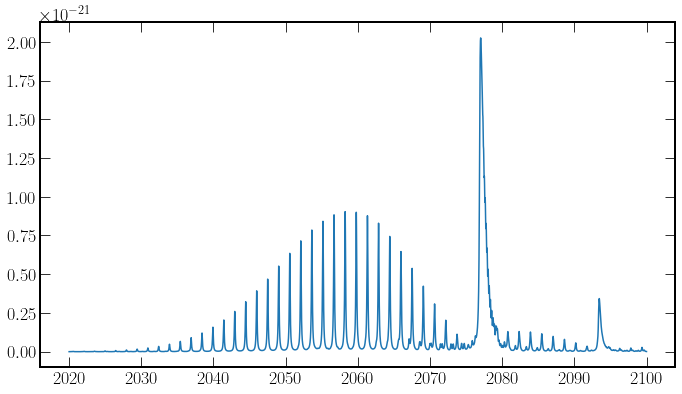

In [10]:
plt.plot(wavnumber, abs_coef)

In [11]:
maximum = np.argmax(abs_coef)
wavnumber[maximum]

2077.0050960000003

##  Standard Atmosphere Model
The "US Standard Atmosphere, 1976"{cite}`USAtmosphere` provides pressure, temperature, and density vertical profiles. The model takes values which are roughly representative of year-round mid-latitude conditions. 

An approximate atmospheric profile is used to calculate molecule concentrations and cross-section broadening. A reasonable assumption in the troposphere is that the relative fractional abundances stay the same. Thus the decrease in atmospheric density provides the main trail off for total absorption. However, the constant relative fraction of greenhouse gases assumption breaks down, particularly for water and ozone fractional abundances above the 10km mark. This is because water forms clouds and precipitates down, becoming much less abundant, and ozone is produced more rapidly at higher altitudes and its concentration peaks in the stratosphere.

Despite falling density and pressure, there is an increase in temperature after $20 km$. This temperature increase is due primarily to Ozone absorbing Shortwave UV-radiation, which is incoming from the sun. This temperature increase is not accounted for in our model as we look at longwave radiation exiting the atmosphere.



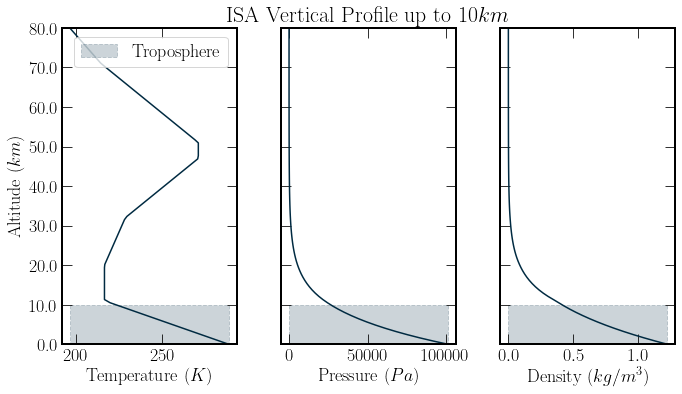

In [16]:
atlittudes = np.linspace(0,80000,100)
temp = isa.get_temperature(atlittudes)
pressure = isa.get_pressure(atlittudes)  
density = isa.get_density(atlittudes)
fig, ax = plt.subplots(1,3,figsize=(10, 6),sharey=True)
labels = ['Temperature $(K)$', 'Pressure $(Pa)$', 'Density $(kg/m^3)$']
for i, profile in enumerate([temp, pressure, density]):
    ax[i].plot(profile, atlittudes, color = colours.durham.ink)
    ax[i].fill_between([np.min(profile),np.max(profile)], [0,0], [10**4,10**4],
               linestyle='--',
               color=colours.durham.ink,
               label='Troposphere',
               alpha=0.2
    )
    ax[i].set_yticks(ax[i].get_yticks(),ax[i].get_yticks()/1000)
    ax[i].set_ylim(0,80000)
    ax[i].set_xlabel(labels[i])
ax[0].set_ylabel('Altitude $(km)$')
ax[1].set_title('ISA Vertical Profile up to $10km$')
ax[0].legend();

## The Variation of the Absorbtion Cross-section of $\textrm{CO}_2$

The HITRAN Database provides the line-by-line intensities for more than 55 molecules. Using the IPCC reports data on the most potent greenhouse gases, the top 3 and water are selected. Water plays a significant role in the greenhouse effect. Notably, its variance in its concentration due to anthropogenic factors is not impactfull on global temperature rise. However, it does provide a large amount of radiation scattering and so should be included{cite}`IPCCAR6`. 

Further, the changes in $\textrm{CO}_2$'s profile can be used as a litmus test for the other gasses, as the underlying mechanisms for Absorption crossectional changes are the same.  

Additionally, to temperature and pressure dependence on the broadening, there is a further temperature dependence on the line intensity due to the accessibility of a given transition. At low temperatures, high-energy transistions, those of low wavelength, are heavily suppressed as the molecules lack the energy to access either the excitation or vibrational mode. A Bose-Einstein distribution quantifies the availability of a transition. When the intensity of a transition is known for one temperature, the ratio of the probabilities gives the intensity
```{math}
:label:
S_{a \rightarrow b}(T) = S_{a \rightarrow b, T_ref}\frac{\exp(-h\nu_{a \rightarrow b} /cK_bT)}{exp(-h\nu_{a \rightarrow b} /cK_b T_{ref})} \frac{Q(T_{ref})}{Q(T)}
```
Where $S_{a \rightarrow b}(T)$ is the line intensity as a function of temperature for some transition $a \rightarrow b$, $\nu_{a \rightarrow b}$ is the wavenumber for the transition, and $Q(T) is the partition sum over all states. The values for $S_{a \rightarrow b}(T_{ref})$ are recorded on the hitran data-base.

$\textrm{CO}_2$'s line intensity variation is plotted at 3 km intervals up to 10km using the ISA model, around the most significant absorption lines, around $650 cm^{-1}$.  

In [50]:
with HiddenPrints():    
    hapi.fetch('CO2', 2, 1, 635,700)
start_alt = 0
stop_alt = 10*1000
alt_band_size = 1000
altitudes = np.arange(start_alt, stop_alt+alt_band_size, alt_band_size)
pressure = isa.get_pressure(altitudes)
temperature = isa.get_temperature(altitudes)
abs_coef_alt = []
integrals = []
cmap = sns.color_palette('rocket', 10)
sm = plt.cm.ScalarMappable(cmap='rocket', norm=plt.Normalize(vmin=0, vmax=30000))
fig, ax = plt.subplots(1,1, figsize=(10, 6))
color_cycle=ax.set_prop_cycle(color=cmap)
for i, (temp, pres) in enumerate(zip(temperature, pressure)):
    with HiddenPrints():
        nu, abs_coef = hapi.absorptionCoefficient_Voigt(SourceTables='CO2',
                    Environment={'T':temp, 'p':pres/pressure[0]},
                    Diluent={'air':1.0}#p in atm
                    )
        abs_coef_alt.append(abs_coef)
    abs_area = simpson(abs_coef, nu,)
    integrals.append(abs_area)
    plot = ax.plot(nu, abs_coef, alpha=0.4)
cb = fig.colorbar(sm)
cb.set_label('Altitude (m)')
#ax.set_ylim(0,2*10**(-21))
ax.set_xlabel('Wavenumber $(cm^{-1})$')
ax.set_ylabel('Absorption Coefficient $(cm^2/molecule)$');

TypeError: 'numpy.int64' object is not iterable

## Optical Density of $\textrm{CO}_2$
The absorption coefficient,$k$, is related to the optical depth at a wavenumber,$nu$, by
```{math}
\tau(\nu, \Delta l, T, p) = \int_{l}^{l+\Delta l} n(z) dz \cdot k(\nu, T, p).
```
Where n(z) is the number density per unit volume. The intensity drop through the medium is related by, 
```{math}
I = I_o e^-\tau.
```
Plotting the optical depth, $I/I_0$, of each block of atmosphere up to $30km$. If we assume that the gas is ideal
```{math}
\Delta n = \int_l^{l+Delta l} \frac{PA}{RT}dz.
```

In [ ]:
def number_density(alt):
    '''
    Returns Number of particles per m^2 
    assuming ideal gas up to alt

    Args:
        alt (float): Altitude in meters.

    Returns:
        float: n(alt) in molecules/m^2
    '''
    return isa.get_pressure(alt)*alt/(isa.get_temperature(alt)
                                        *constants.R)
def particle_per_sq_m(alt_0, alt_1):
    '''
    returns number of particles per square meter
    between two altitudes

    Args:
        alt_0 (float):
        alt_1 (float): 

    Returns:
        float: 
    '''
    return number_density(alt_0) + quad(number_density, alt_0, alt_1)

def optical_depth(alt_0, alt_1, ppm_conc, abs_coef):
    particles = particle_per_sq_m(alt_0, alt_1)*ppm_conc * 10**6
    return particles*abs_coef*10**(-4) #10^-4 factor from cm^2->m^2 conv

In [ ]:
mid_pt_alt = np.arange(start_alt + alt_band_size/2,
                       stop_alt + alt_band_size/2,
                       alt_band_size
)
mid_pt_alt

NameError: name 'start_alt' is not defined